In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import time 
from sklearn.metrics import mean_squared_error

'''
None || 20000 || 100000
'''
nb = None
nb_trains = nb
nb_valids = nb
nb_tests = nb

N_past = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/Projects/JPX_Tokyo_Stock/working


/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/working


In [ ]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 937 kB/s 
     |████████████████████████████████| 209 kB 87.7 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 146 kB 71.6 MB/s 
     |████████████████████████████████| 112 kB 74.1 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=b008932e3c77d986035653c2b5938b5dc6956ad385547b3d295c833ddc438fe3
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from data_utils import *

#### Load Data

In [ ]:
train_df = pd.read_csv('../__input__/2_after_featureEngineering/train_full.csv', parse_dates=['Date'], nrows = nb_trains)
valid_df = pd.read_csv('../__input__/2_after_featureEngineering/valid_full.csv', parse_dates=['Date'], nrows = nb_valids)
test_df = pd.read_csv('../__input__/2_after_featureEngineering/test_full.csv', parse_dates=['Date'], nrows = nb_tests)
y_test_df = pd.read_csv('../__input__/2_after_featureEngineering/y_test_full.csv', parse_dates=['Date'], nrows = nb_tests)

hidden_test_df = pd.read_csv('../__input__/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv', nrows = None, parse_dates=['Date'])

In [ ]:
mini_train_after_dataPreprocessing = pd.read_csv('../__input__/1_DataPreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)
mini_train_after_featureEngineering = pd.read_csv('../__input__/2_after_featureEngineering/mini_train.csv', parse_dates=['Date'], nrows = None)

In [ ]:
hidden_test_df = FeatureEngineering_for_hidden_test(DataPreprocessing_for_hidden_test(hidden_test_df, mini_train_after_dataPreprocessing), mini_train_after_featureEngineering, N_past)

/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/working/data_utils.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return['ExpectedDividend'] = df_return['ExpectedDividend'].fillna(-1)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
def drop_date_features(df):
    df = df.drop([
        'dayofyear', 
        'dayofweek', 
        'week', 
        'is_month_end', 
        'is_month_start',
        'is_year_end',
        'is_year_start',
    ], axis = 1, inplace= True)

In [ ]:
drop_date_features(train_df)
drop_date_features(valid_df)
drop_date_features(test_df)
drop_date_features(hidden_test_df)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4573509 entries, 0 to 4573508
Data columns (total 57 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Date                datetime64[ns]
 1   SecuritiesCode      int64         
 2   Volume              float64       
 3   AdjustmentFactor    float64       
 4   ExpectedDividend    float64       
 5   SupervisionFlag     bool          
 6   Target              float64       
 7   CloseT2             float64       
 8   Close               float64       
 9   CloseT1             float64       
 10  Range_HL            float64       
 11  Range_OC            float64       
 12  Year                int64         
 13  Month               int64         
 14  Day                 int64         
 15  Close_1_before      float64       
 16  Range_HL_1_before   float64       
 17  Range_OC_1_before   float64       
 18  Volume_1_before     float64       
 19  Close_2_before      float64       
 20  Ra

In [ ]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233223 entries, 0 to 233222
Data columns (total 57 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                233223 non-null  datetime64[ns]
 1   SecuritiesCode      233223 non-null  int64         
 2   Volume              233223 non-null  float64       
 3   AdjustmentFactor    233223 non-null  float64       
 4   ExpectedDividend    233223 non-null  float64       
 5   SupervisionFlag     233223 non-null  bool          
 6   Target              233223 non-null  float64       
 7   CloseT2             233223 non-null  float64       
 8   Close               233223 non-null  float64       
 9   CloseT1             233223 non-null  float64       
 10  Range_HL            233223 non-null  float64       
 11  Range_OC            233223 non-null  float64       
 12  Year                233223 non-null  int64         
 13  Month               233223 no

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229952 entries, 0 to 229951
Data columns (total 54 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                229952 non-null  datetime64[ns]
 1   SecuritiesCode      229952 non-null  int64         
 2   Volume              229952 non-null  float64       
 3   AdjustmentFactor    229952 non-null  float64       
 4   ExpectedDividend    229952 non-null  float64       
 5   SupervisionFlag     229952 non-null  bool          
 6   Close               229952 non-null  float64       
 7   Range_HL            229952 non-null  float64       
 8   Range_OC            229952 non-null  float64       
 9   Year                229952 non-null  int64         
 10  Month               229952 non-null  int64         
 11  Day                 229952 non-null  int64         
 12  Close_1_before      229952 non-null  float64       
 13  Range_HL_1_before   229952 no

In [ ]:
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229952 entries, 0 to 229951
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SecuritiesCode  229952 non-null  int64         
 1   Date            229952 non-null  datetime64[ns]
 2   CloseT1         229952 non-null  float64       
 3   CloseT2         229952 non-null  float64       
 4   Target          229952 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 8.8 MB


In [ ]:
hidden_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                4000 non-null   datetime64[ns]
 1   SecuritiesCode      4000 non-null   int64         
 2   Volume              4000 non-null   float64       
 3   AdjustmentFactor    4000 non-null   float64       
 4   ExpectedDividend    4000 non-null   float64       
 5   SupervisionFlag     4000 non-null   bool          
 6   Close               4000 non-null   float64       
 7   Range_HL            4000 non-null   float64       
 8   Range_OC            4000 non-null   float64       
 9   Year                4000 non-null   int64         
 10  Month               4000 non-null   int64         
 11  Day                 4000 non-null   int64         
 12  Close_1_before      4000 non-null   float64       
 13  Range_HL_1_before   4000 non-null   float64     

### Calc Scores

In [ ]:
def calc_spread_return_per_day(df, portfolio_size: int = 200, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df: pd.DataFrame, y_pred):
    df["Pred"] = y_pred
    df["Rank"] = df.groupby("Date")["Pred"].rank(ascending=False, method="first") - 1 
    df = df.drop("Pred", axis= 1)
    return df

In [ ]:
def calc_score(df: pd.DataFrame, y_pred: pd.DataFrame, y_true: pd.DataFrame, render_info= True):
    feature_df = df.copy()
    feature_df = add_rank(feature_df, y_pred)
    feature_df['Target'] = y_true
    score, buf = calc_spread_return_sharpe(feature_df)
    if render_info:
        print(f'score -> {score}\nmean -> {buf.mean()}\nstd -> {buf.std()}')
    del feature_df
    return score

In [ ]:
calc_score(test_df, y_test_df["Target"], y_test_df["Target"])

score -> 4.687380919991682
mean -> 15.446241603409499
std -> 3.2952819211963917


4.687380919991682

### Cross Validation

In [ ]:
featureCols = train_df.drop(["Target", "CloseT1", "CloseT2"], axis = 1).columns
featureCols

Index(['Date', 'SecuritiesCode', 'Volume', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'Close', 'Range_HL', 'Range_OC',
       'Year', 'Month', 'Day', 'Close_1_before', 'Range_HL_1_before',
       'Range_OC_1_before', 'Volume_1_before', 'Close_2_before',
       'Range_HL_2_before', 'Range_OC_2_before', 'Volume_2_before',
       'Close_3_before', 'Range_HL_3_before', 'Range_OC_3_before',
       'Volume_3_before', 'Close_4_before', 'Range_HL_4_before',
       'Range_OC_4_before', 'Volume_4_before', 'Close_5_before',
       'Range_HL_5_before', 'Range_OC_5_before', 'Volume_5_before',
       'Close_6_before', 'Range_HL_6_before', 'Range_OC_6_before',
       'Volume_6_before', 'Close_7_before', 'Range_HL_7_before',
       'Range_OC_7_before', 'Volume_7_before', 'Close_8_before',
       'Range_HL_8_before', 'Range_OC_8_before', 'Volume_8_before',
       'Close_9_before', 'Range_HL_9_before', 'Range_OC_9_before',
       'Volume_9_before', 'Close_10_before', 'Range_HL_10_

In [ ]:
X_train = train_df[featureCols]
X_train["Date"] = X_train["Date"].astype(str)
y_train = train_df["Target"]

X_valid = valid_df[featureCols]
X_valid["Date"] = X_valid["Date"].astype(str)
y_valid = valid_df["Target"]

X_test = test_df[featureCols]
X_test["Date"] = X_test["Date"].astype(str)
y_test = y_test_df["Target"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
calc_score(X_test, y_test, y_test)

score -> 4.687380919991682
mean -> 15.446241603409499
std -> 3.2952819211963917


4.687380919991682

#### Optuna tuning

In [ ]:
x_train_optuna = X_train.drop("Date", axis = 1)
y_train_optuna = y_train
x_eval_optuna = X_valid
x_eval_not_date = X_valid.drop("Date", axis = 1)
y_eval_optuna = y_valid

In [ ]:
def objective(
    trial,
    random_state=22,
    n_jobs=-1,
):
    # XGBoost parameters
    params = {
        'tree_method':'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "max_depth": trial.suggest_int("max_depth", 11, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.6, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
        "early_stopping_rounds": 50,
        "eval_metric": "rmse"
        
    }

    model = xgb.XGBRegressor(**params) 

    model.fit(
        x_train_optuna,
        y_train_optuna,
        eval_set=[(x_eval_not_date, y_eval_optuna)],
        verbose=0,
    )
    y_pred = pd.DataFrame(model.predict(x_eval_not_date), columns =['Target'])
    del model
    time.sleep(10)
    return calc_score(x_eval_optuna, y_pred, y_eval_optuna, render_info= False)

In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, gc_after_trial=True)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-06-20 15:31:08,720] A new study created in memory with name: no-name-02cd9fd4-810f-464a-84b2-fc6267043857
[I 2022-06-20 15:37:37,694] Trial 0 finished with value: 0.25888523342314457 and parameters: {'max_depth': 20, 'learning_rate': 0.019764059262351235, 'colsample_bytree': 0.49191965104381385, 'subsample': 0.6406000815846024, 'alpha': 0.20005558011922056, 'lambda': 3.7444590362457106e-07, 'min_child_weight': 235.79799184424}. Best is trial 0 with value: 0.25888523342314457.
[I 2022-06-20 15:42:03,920] Trial 1 finished with value: 0.26329200802972247 and parameters: {'max_depth': 14, 'learning_rate': 0.01595247453739111, 'colsample_bytree': 0.3258200120116372, 'subsample': 0.764880982014564, 'alpha': 0.7858641446797869, 'lambda': 0.4513697075484242, 'min_child_weight': 212.69453957938953}. Best is trial 1 with value: 0.26329200802972247.
[I 2022-06-20 15:51:24,375] Trial 2 finished with value: 0.23942359572631092 and parameters: {'max_depth': 19, 'learning_rate': 0.00896375752

Number of finished trials: 10
Best trial: {'max_depth': 16, 'learning_rate': 0.022901118682466037, 'colsample_bytree': 0.21038536285403944, 'subsample': 0.7375803283755273, 'alpha': 0.09149498396871379, 'lambda': 0.3142171441292158, 'min_child_weight': 16.020178888048452}
CPU times: user 57min 37s, sys: 41.8 s, total: 58min 19s
Wall time: 59min 37s


In [ ]:
# best_params = {
# 'alpha': 0.09149498396871379,
#  'colsample_bytree': 0.21038536285403944,
#  'early_stopping_rounds': 50,
#  'lambda': 0.3142171441292158,
#  'learning_rate': 0.022901118682466037,
#  'max_depth': 16,
#  'min_child_weight': 16.020178888048452,
#  'early_stopping_rounds': 50,
#  'eval_metric': 'rmse',
#  'n_estimators': 1000,
#  'n_jobs': -1,
#  'objective': 'reg:squarederror',
#  'seed': 22,
#  'tree_method': 'gpu_hist',
#  'verbosity': 0}

In [ ]:
best_params = study.best_trial.params
best_params['tree_method'] = 'gpu_hist'
best_params['verbosity'] = 0
best_params['objective'] = "reg:squarederror"
best_params['n_estimators'] = 1000
best_params['seed'] = 22
best_params['n_jobs'] = -1
best_params["early_stopping_rounds"] = 50
best_params["eval_metric"] = "rmse"

best_params

{'alpha': 0.09149498396871379,
 'colsample_bytree': 0.21038536285403944,
 'early_stopping_rounds': 50,
 'eval_metric': 'rmse',
 'lambda': 0.3142171441292158,
 'learning_rate': 0.022901118682466037,
 'max_depth': 16,
 'min_child_weight': 16.020178888048452,
 'n_estimators': 1000,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'seed': 22,
 'subsample': 0.7375803283755273,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

In [ ]:
%%time
model = xgb.XGBRegressor(**best_params) 

model.fit(
    X_train.drop("Date", axis = 1),
    y_train,
    eval_set=[(X_valid.drop("Date", axis = 1), y_valid)],
    verbose=0,
)

CPU times: user 9min 36s, sys: 5.29 s, total: 9min 41s
Wall time: 9min 38s


In [ ]:
%%time
y_pred = pd.DataFrame(model.predict(X_train.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_train, y_pred, y_train, render_info= False))

4.600380923353775
CPU times: user 29.9 s, sys: 7.95 s, total: 37.8 s
Wall time: 36.7 s


In [ ]:
np.sqrt(mean_squared_error(y_pred, y_train))

0.018912147287529643

In [ ]:
%%time
y_pred = pd.DataFrame(model.predict(X_valid.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_valid, y_pred, y_valid, render_info= False))

0.2690834613674246
CPU times: user 1.75 s, sys: 196 ms, total: 1.95 s
Wall time: 1.93 s


In [ ]:
np.sqrt(mean_squared_error(y_pred, y_valid))

0.028246121622095013

In [ ]:
%%time
y_pred = pd.DataFrame(model.predict(X_test.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_test, y_pred, y_test, render_info= False))

0.08675856793489078
CPU times: user 1.74 s, sys: 188 ms, total: 1.93 s
Wall time: 1.89 s


In [ ]:
np.sqrt(mean_squared_error(y_pred, y_test))

0.024850405023798487

In [ ]:
def render_feature_important(model_xgboost, df_trained):
  feature_important = model.feature_importances_
  sorted_idx = np.argsort(feature_important)[::-1]

  keys = df_trained.columns[sorted_idx]
  values = feature_important[sorted_idx]

  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
  data.plot(kind='barh', figsize = (20,10))

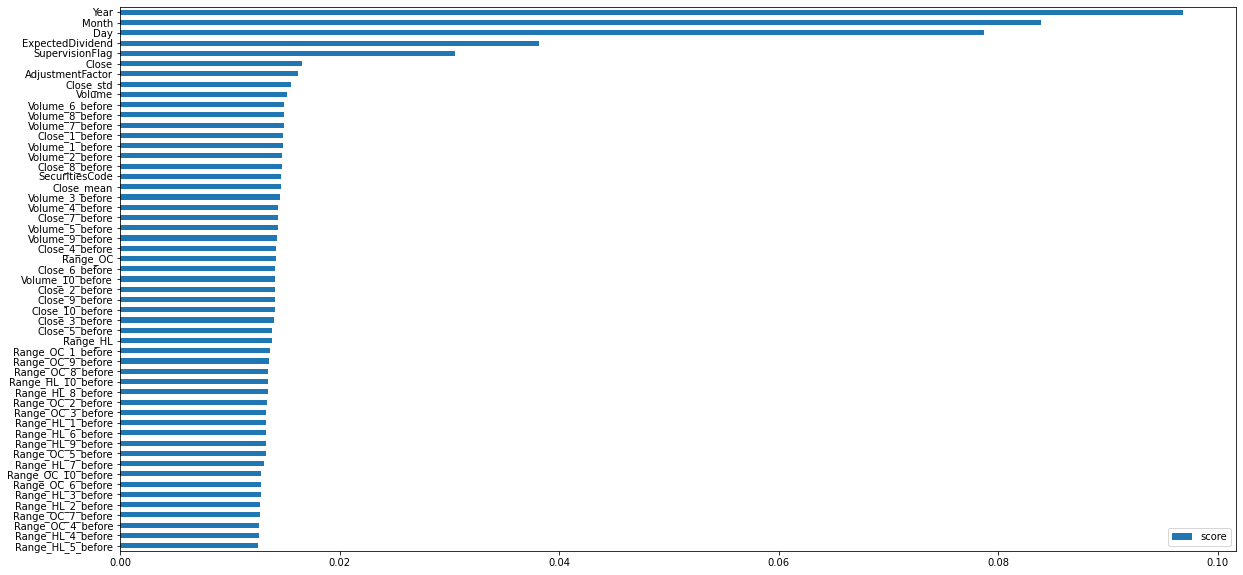

In [ ]:
render_feature_important(model, X_train.drop("Date", axis = 1))

#### test pred hidden_test

In [ ]:
hidden_test_df = pd.read_csv('../__input__/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv', nrows = None, parse_dates=['Date'])
mini_train_after_dataPreprocessing = pd.read_csv('../__input__/1_DataPreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)

In [ ]:
hidden_test_df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
3995,20211207_9990,2021-12-07,9990,526.0,535.0,524.0,535.0,57800,1.0,NaN,False
3996,20211207_9991,2021-12-07,9991,795.0,806.0,792.0,805.0,48500,1.0,NaN,False
3997,20211207_9993,2021-12-07,9993,1640.0,1640.0,1620.0,1620.0,6600,1.0,NaN,False
3998,20211207_9994,2021-12-07,9994,2437.0,2440.0,2423.0,2440.0,5200,1.0,NaN,False


In [ ]:
y_test_official = DataPreprocessing_for_hidden_test(hidden_test_df, mini_train_after_dataPreprocessing)
y_test_official

/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/working/data_utils.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_return['ExpectedDividend'] = df_return['ExpectedDividend'].fillna(-1)


,Date,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Open,High,Low,Close
0,2021-12-06,1301,8900,1.0,-1.0,False,2982.0,2982.0,2965.0,2971.0
1,2021-12-06,1332,1360800,1.0,-1.0,False,592.0,599.0,588.0,589.0
2,2021-12-06,1333,125900,1.0,-1.0,False,2368.0,2388.0,2360.0,2377.0
3,2021-12-06,1375,81100,1.0,-1.0,False,1230.0,1239.0,1224.0,1224.0
4,2021-12-06,1376,6200,1.0,-1.0,False,1339.0,1372.0,1339.0,1351.0
...,...,...,...,...,...,...,...,...,...,...
3995,2021-12-07,9990,57800,1.0,-1.0,False,526.0,535.0,524.0,535.0
3996,2021-12-07,9991,48500,1.0,-1.0,False,795.0,806.0,792.0,805.0
3997,2021-12-07,9993,6600,1.0,-1.0,False,1640.0,1640.0,1620.0,1620.0
3998,2021-12-07,9994,5200,1.0,-1.0,False,2437.0,2440.0,2423.0,2440.0
